# Example Ising Model

This is from the following video: https://youtube.com/watch?v=K--1hlv9yv0&feature=share

Hopefully, this will provide a useful guide for us moving forward.

In [1]:
pip install SciencePlots

Note: you may need to restart the kernel to use updated packages.


In [2]:
import scienceplots

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science','notebook', 'grid'])
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

In [4]:
# we will make a 50x50 grid
N = 50

In [5]:
# +1 is spin up
# - 1 is spin down
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

# init_random = np.random.random((N,N))
# lattice_p = np.zeros((N, N))
# lattice_p[init_random>=0.25] = 1
# lattice_p[init_random<0.25] = -1

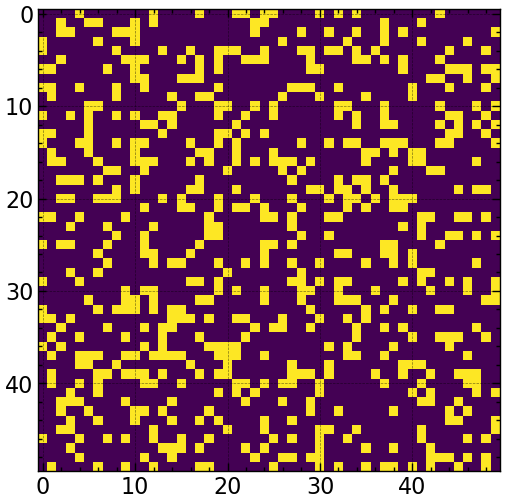

In [6]:
plt.imshow(lattice_n)

Function to get energy
Dimensionless quantities
$E/J = - \sum_{<i,j>} \sigma_i \sigma_j$

In [29]:
def get_energy(lattice):
    # applies the nearest neighbors summation
    
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generate_binary_structure.html
    # generate_binary_structure(rank, connectivity)
    # rank = integer (number of dimensions of the array to which the structuring element will be applied)
    # connectivity = integer (determines which elements of the output array belong to the structure, as in considered neighbors of the central element)
    kern = generate_binary_structure (2,1)
    kern [1][1] = False
    
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html
    arr = -lattice * convolve(lattice, kern, mode = "constant", cval = 0)
    # what does the arr.sum do?
    return arr.sum()

# What the shiet is going on???

In [23]:
kern = generate_binary_structure (2,1)
kern [1][1] = False

In [24]:
kern

array([[False,  True, False],
       [ True, False,  True],
       [False,  True, False]])

In [25]:
lattice_n

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1.,  1., ..., -1., -1., -1.],
       [-1., -1.,  1., ..., -1., -1.,  1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1.,  1., -1.],
       [-1.,  1., -1., ..., -1.,  1., -1.]])

In [30]:
print(get_energy(lattice_n))

[[-2. -3. -1. ... -3. -3. -2.]
 [-3. -2.  2. ... -4. -4. -1.]
 [-1. -2. -0. ... -4. -2.  3.]
 ...
 [-1. -4. -2. ... -4.  0. -3.]
 [-3. -2. -4. ...  0.  2. -1.]
 [ 0.  3. -1. ... -1.  1.  0.]]
-2320.0


In [37]:
bob = generate_binary_structure (2,1)
bob[1][1] = False
bob

array([[False,  True, False],
       [ True, False,  True],
       [False,  True, False]])

In [28]:
x.sum()

AttributeError: 'list' object has no attribute 'sum'

In [ ]:
# what is numba??
@numba.njit("UniTuple(f8[:],2)(f8[:,:],i8, f8, f8)", nopython=True, nogil = True)

# f8[:,:] initial state of spins
# i8 = initial rate times
# f8 is BJ is dependent on temperature
# f8 is based on initial energy

def metropolis(spin_arr, times, BJ, energy):
    spin_arry = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    